In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import f1_score, PrecisionRecallDisplay, precision_score, recall_score, roc_auc_score, RocCurveDisplay, roc_curve, confusion_matrix
from sklearn.linear_model import LogisticRegression
from datetime import timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV #GridSearch is for hyperparameter tuning
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, PrecisionRecallDisplay, RocCurveDisplay

In [61]:
# read all tables
customers = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/customers_final.csv')
engagement = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/engagements_final.csv')
marketing = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/marketing_final.csv')
transactions = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/transactions_final.csv')

In [62]:
# example 1: join at customer level with # of marketing campaigns customer responded YES to
# step 1: marketing data at a customer level
marketing_agg = marketing[marketing['response']=='Yes'].groupby('customer_id')['campaign_id'].count().to_frame()

In [63]:
# step 2: aggregate transaction data at a customer level
transactions_agg = transactions.groupby('customer_id').aggregate({'transaction_id':'count','transaction_amount':'sum'})

In [64]:
# step 3: set customers and engagement index as customer_id
customers.set_index('customer_id', inplace=True)
engagement.set_index('customer_id', inplace=True)

In [65]:
# step 4: join all tables
joint_data = customers.join(engagement).join(transactions_agg).join(marketing_agg)
joint_data

,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_amount,campaign_id
customer_id,,,,,,,,,,,
1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,6,3509.48,1.0
2,2021-09-08,2023-10-25,NaN,Male,Hillville,285,49,51,9,6081.32,2.0
3,2021-06-01,2022-11-27,NaN,NaN,North Latoyatown,192,73,25,6,1454.87,1.0
4,2022-01-01,2022-09-01,29.0,Male,Grossstad,110,30,17,20,7874.68,1.0
5,2022-01-24,2023-06-02,NaN,Male,East Matthewfort,161,2,7,24,15524.55,NaN
...,...,...,...,...,...,...,...,...,...,...,...
9996,2022-12-16,2023-08-13,42.0,Female,Johnstonborough,119,47,16,10,5498.20,NaN
9997,2022-07-09,2023-01-25,26.0,Male,Jessicamouth,3,33,14,12,5848.30,1.0
9998,2023-09-17,2024-01-30,39.0,Male,New John,53,17,5,3,3503.13,1.0


In [66]:
# Calculation of LTV
joint_data.groupby('customer_id')['transaction_amount'].sum()

customer_id
1         3509.48
2         6081.32
3         1454.87
4         7874.68
5        15524.55
           ...   
9996      5498.20
9997      5848.30
9998      3503.13
9999      6721.86
10000     5775.83
Name: transaction_amount, Length: 10000, dtype: float64

In [67]:
joint_data['LTV'] = joint_data.groupby('customer_id')['transaction_amount'].sum()
joint_data

,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_amount,campaign_id,LTV
customer_id,,,,,,,,,,,,
1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,6,3509.48,1.0,3509.48
2,2021-09-08,2023-10-25,NaN,Male,Hillville,285,49,51,9,6081.32,2.0,6081.32
3,2021-06-01,2022-11-27,NaN,NaN,North Latoyatown,192,73,25,6,1454.87,1.0,1454.87
4,2022-01-01,2022-09-01,29.0,Male,Grossstad,110,30,17,20,7874.68,1.0,7874.68
5,2022-01-24,2023-06-02,NaN,Male,East Matthewfort,161,2,7,24,15524.55,NaN,15524.55
...,...,...,...,...,...,...,...,...,...,...,...,...
9996,2022-12-16,2023-08-13,42.0,Female,Johnstonborough,119,47,16,10,5498.20,NaN,5498.20
9997,2022-07-09,2023-01-25,26.0,Male,Jessicamouth,3,33,14,12,5848.30,1.0,5848.30
9998,2023-09-17,2024-01-30,39.0,Male,New John,53,17,5,3,3503.13,1.0,3503.13


In [68]:
# Convert transaction_date to datetime
transactions['transaction_date'] = pd.to_datetime(transactions['transaction_date'])

In [69]:
# customer age
joint_data['Customer_Age'] = pd.to_datetime(joint_data['last_purchase_date']) - pd.to_datetime(joint_data['join_date'])
joint_data['Customer_Age']

customer_id
1       118 days
2       777 days
3       544 days
4       243 days
5       494 days
          ...   
9996    240 days
9997    200 days
9998    135 days
9999     66 days
10000    98 days
Name: Customer_Age, Length: 10000, dtype: timedelta64[ns]

In [70]:
# Avg transaction amount
joint_data['Avg_Transaction_Amount'] = (joint_data['LTV'])/(joint_data['transaction_id'])
joint_data


,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_amount,campaign_id,LTV,Customer_Age,Avg_Transaction_Amount
customer_id,,,,,,,,,,,,,,
1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,6,3509.48,1.0,3509.48,118 days,584.913333
2,2021-09-08,2023-10-25,NaN,Male,Hillville,285,49,51,9,6081.32,2.0,6081.32,777 days,675.702222
3,2021-06-01,2022-11-27,NaN,NaN,North Latoyatown,192,73,25,6,1454.87,1.0,1454.87,544 days,242.478333
4,2022-01-01,2022-09-01,29.0,Male,Grossstad,110,30,17,20,7874.68,1.0,7874.68,243 days,393.734000
5,2022-01-24,2023-06-02,NaN,Male,East Matthewfort,161,2,7,24,15524.55,NaN,15524.55,494 days,646.856250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,2022-12-16,2023-08-13,42.0,Female,Johnstonborough,119,47,16,10,5498.20,NaN,5498.20,240 days,549.820000
9997,2022-07-09,2023-01-25,26.0,Male,Jessicamouth,3,33,14,12,5848.30,1.0,5848.30,200 days,487.358333
9998,2023-09-17,2024-01-30,39.0,Male,New John,53,17,5,3,3503.13,1.0,3503.13,135 days,1167.710000


In [193]:
# Most Recent Purchase (in days)
joint_data['most_recent_purchase_date'] = pd.to_datetime(joint_data['last_purchase_date'].max()) - pd.to_datetime(joint_data['last_purchase_date'])

In [164]:
# RFM Model
# Convert transaction dates to datetime
transactions['transaction_date'] = pd.to_datetime(transactions['transaction_date'])

In [165]:
# Set the current date as the day after the last transaction in the dataset for recency calculation
now = transactions['transaction_date'].max() + pd.Timedelta(days=1)

In [166]:
# Calculating RFM metrics
rfm = transactions.groupby('customer_id').agg({
    'transaction_date': lambda x: (now - x.max()).days,  # Recency: days since last transaction
    'transaction_id': 'count',  # Frequency: number of transactions
    'transaction_amount': 'sum'   # Monetary: total amount spent
}).rename(columns={
    'transaction_date': 'Recency',
    'transaction_id': 'Frequency',
    'transaction_amount': 'Monetary'
})

In [167]:
# Assign RFM scores using quintiles for each metric
# We handle cases where there are not enough quantiles with duplicates='drop'
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5, 4, 3, 2, 1], duplicates='drop')
rfm['F_Score'] = pd.qcut(rfm['Frequency'], 5, labels=[1, 2, 3, 4, 5], duplicates='drop')
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, labels=[1, 2, 3, 4, 5], duplicates='drop')

In [170]:
# Combine the scores
rfm['RFM_Score'] = rfm[['R_Score', 'F_Score', 'M_Score']].sum(axis=1)
rfm

,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score
customer_id,,,,,,,
1,81,6,3509.48,5,1,2,8
2,461,9,6081.32,3,2,3,8
3,561,6,1454.87,2,1,1,4
4,640,20,7874.68,2,4,3,9
5,366,24,15524.55,3,5,5,13
...,...,...,...,...,...,...,...
9996,356,10,5498.20,3,2,2,7
9997,541,12,5848.30,2,3,2,7
9998,152,3,3503.13,4,1,2,7


In [134]:
# Customer Tier
def Customer_Tier(x):
    if x<=10:
        return 'inactive online'
    if x>=11 and x<100:
        return 'regularly checks online'
    if x>=100:
        return 'actively engaged'
    else:
        return 'member'

In [135]:
joint_data['Customer_Tier'] = joint_data['number_of_site_visits'].apply(Customer_Tier)
joint_data

,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_amount,campaign_id,LTV,Customer_Age,Avg_Transaction_Amount,most_recent_purchase_date,Customer_Tier,Customer_Age_Days
customer_id,,,,,,,,,,,,,,,,,
1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,6,3509.48,1.0,3509.48,118 days,584.913333,2024-03-17,inactive online,118
2,2021-09-08,2023-10-25,NaN,Male,Hillville,285,49,51,9,6081.32,2.0,6081.32,777 days,675.702222,2023-10-25,actively engaged,777
3,2021-06-01,2022-11-27,NaN,NaN,North Latoyatown,192,73,25,6,1454.87,1.0,1454.87,544 days,242.478333,2022-11-27,actively engaged,544
4,2022-01-01,2022-09-01,29.0,Male,Grossstad,110,30,17,20,7874.68,1.0,7874.68,243 days,393.734000,2022-09-01,actively engaged,243
5,2022-01-24,2023-06-02,NaN,Male,East Matthewfort,161,2,7,24,15524.55,NaN,15524.55,494 days,646.856250,2023-06-02,actively engaged,494
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,2022-12-16,2023-08-13,42.0,Female,Johnstonborough,119,47,16,10,5498.20,NaN,5498.20,240 days,549.820000,2023-08-13,actively engaged,240
9997,2022-07-09,2023-01-25,26.0,Male,Jessicamouth,3,33,14,12,5848.30,1.0,5848.30,200 days,487.358333,2023-01-25,inactive online,200
9998,2023-09-17,2024-01-30,39.0,Male,New John,53,17,5,3,3503.13,1.0,3503.13,135 days,1167.710000,2024-01-30,regularly checks online,135


In [183]:
tier_counts = joint_data['Customer_Tier'].value_counts()

NameError: name 'joint_datadf' is not defined

In [172]:
#RFM Model (30 days)
# Convert 'TransactionDate' to datetime
transactions['transaction_date'] = pd.to_datetime(transactions['transaction_date'])

In [173]:
# Set the current date to the latest date in the dataset for a consistent reference
current_date = transactions['transaction_date'].max()

In [174]:
# Filter transactions to the last 30 days
recent_transactions = transactions[transactions['transaction_date'] > current_date - timedelta(days=30)]

In [175]:
# Calculate RFM metrics
rfm = recent_transactions.groupby('customer_id').agg({
    'transaction_date': lambda x: (current_date - x.max()).days,  # Recency
    'transaction_id': 'count',  # Frequency
    'transaction_amount': 'sum'   # Monetary
}).rename(columns={
    'transaction_date': 'Recency',
    'transaction_id': 'Frequency',
    'transaction_amount': 'Monetary'
})

In [176]:
# Assign RFM scores 
rfm['R_Score'] = pd.qcut(rfm_30_days['Recency'], 5, labels=[5, 4, 3, 2, 1], duplicates='drop')
rfm['F_Score'] = pd.qcut(rfm_30_days['Frequency'], 5, labels=[1, 2, 3, 4, 5], duplicates='drop')
rfm['M_Score'] = pd.qcut(rfm_30_days['Monetary'], 5, labels=[1, 2, 3, 4, 5], duplicates='drop')

In [177]:
# Combine the scores into a single string score
rfm['RFM_Score_30_days'] = rfm[['R_Score', 'F_Score', 'M_Score']].sum(axis=1)
rfm

,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score_30_days
customer_id,,,,,,,
7,13,3,1018.16,3,2,2,7
48,19,1,439.69,2,1,1,4
59,24,8,4848.62,1,3,3,7
66,8,20,10795.72,3,4,4,11
90,1,19,11212.55,4,4,4,12
...,...,...,...,...,...,...,...
9869,28,1,408.71,1,1,1,3
9873,1,20,8405.83,4,4,4,12
9875,28,1,114.28,1,1,1,3


In [185]:
counts = joint_data['Customer_Tier'].value_counts()
plot_data = pd.DataFrame({
    "Customer_Tier": counts.index,
    "Counts": counts.values
})

<Axes: xlabel='Customer_Tier', ylabel='Count'>

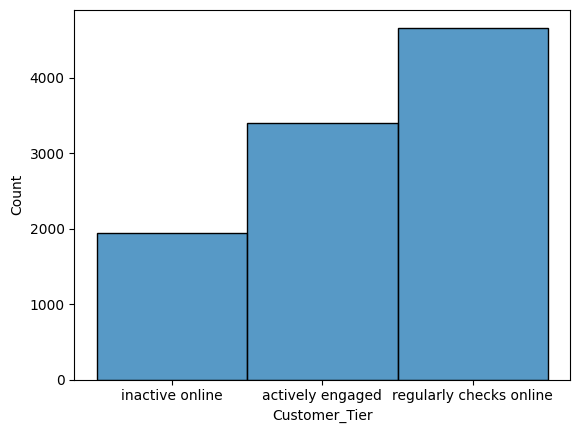

In [191]:
sns.histplot(joint_data['Customer_Tier'])

## REGRESSION MODEL

In [194]:
# split data into X variables and y variable
X = joint_data[['Customer_Tier', 'Customer_Age', 'most_recent_purchase_date']]
y = joint_data['transaction_amount']

In [195]:
# reserve 30% for testing
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

In [3]:
model_2 = RandomForestRegressor(n_estimators=100, random_state=1234)
model_2.fit(X_train, y_train)

NameError: name 'RandomForestRegressor' is not defined